In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchdiffeq import odeint  
import numpy as np
import os
import pickle

def get_texture_folders(root_dir):
    return [os.path.join(root_dir, texture) for texture in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, texture))]


class TextureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_pairs = self._load_file_pairs()
    
    def _load_file_pairs(self):
        file_pairs = []
        texture_folders = get_texture_folders(self.root_dir)
        
        for texture_folder in texture_folders:
            texture_name = texture_folder.split("\\")[1]
            
            files = os.listdir(texture_folder)
            base_names = set(f.split(".")[0] for f in files)
            
            for base in base_names:
                image_path = os.path.join(texture_folder, f"{base}.jpg")
                heightmap_path = os.path.join(texture_folder, f"{base}.pkl")
                
                if os.path.exists(image_path) and os.path.exists(heightmap_path):
                    file_pairs.append((image_path, heightmap_path))
        
        return file_pairs
    
    def __len__(self):
        return len(self.file_pairs)
    
    def __getitem__(self, idx):
        image_path, heightmap_path = self.file_pairs[idx]
        image = Image.open(image_path).convert("RGB")
        with open(heightmap_path, 'rb') as f:
            heightmap = pickle.load(f).astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
            heightmap = self.transform(heightmap)
        
        return image, heightmap


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize((0.5,), (0.5,))
])

root_dir = "../../Texture"
dataset = TextureDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [16]:
import math

# TimestepEmbedder from https://github.com/cloneofsimo/minRF
class TimestepEmbedder(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half) / half
        ).to(t.device)
        args = t[:, None] * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size).to(
            dtype=next(self.parameters()).dtype
        )
        t_emb = self.mlp(t_freq)
        return t_emb

In [17]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi
    
class ConvBlock(nn.Module):
    # Convolution block with time step embedding
    def __init__(self, in_channels, out_channels, time_emb_dim=1024):
        super(ConvBlock, self).__init__()
        self.fc = nn.Linear(time_emb_dim, in_channels)
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU()
        )
        
    def forward(self, x, temb):
        x += self.fc(temb)[:, :, None, None]
        return self.conv_block(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, num_layers=4, base_channels=64):
        super(UNet, self).__init__()
        
        time_emb_dim = 256
        
        self.pool = nn.MaxPool2d(2)
        
        self.t_embedder = TimestepEmbedder(time_emb_dim)
        
        self.encoder_layers = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()
        self.upsample_layers = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()
        
        in_channels = input_channels
        out_channels = base_channels
        # Construct encoder layers
        # (1, 64) -> (64, 128) -> (128, 256) -> (256, 512)
        for _ in range(num_layers):
            self.encoder_layers.append(ConvBlock(in_channels, out_channels, time_emb_dim))
            in_channels = out_channels
            out_channels *= 2
            
        self.bottleneck_layers = nn.ModuleList([
            ConvBlock(in_channels, out_channels, time_emb_dim),   # (512, 1024)
            ConvBlock(out_channels, out_channels, time_emb_dim)   # (1024, 1024)
        ])
        
        # Construct decoder and upsample layers
        # (1024, 512) -> (512, 256) -> (256, 128) -> (128, 64)
        for _ in range(num_layers):
            in_channels = out_channels
            out_channels = in_channels // 2
            self.upsample_layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2))
            self.attention_blocks.append(Attention_block(out_channels, out_channels, out_channels//2))
            self.decoder_layers.append(ConvBlock(in_channels, out_channels, time_emb_dim))
        
        # Output layer (64, 1)
        self.output_layer = nn.Conv2d(out_channels, output_channels, kernel_size=1)
    
    def forward(self, x, t):
        t = self.t_embedder(t)
        
        encoder_outs = []

        for layer in self.encoder_layers:
            x = layer(x, t)
            encoder_outs.append(x)
            x = self.pool(x)
        
        for layer in self.bottleneck_layers:
            x = layer(x, t)
            
        for i in range(len(self.decoder_layers)):
            x = self.upsample_layers[i](x)
            # Attention blocks
            encoder_outs[-(i + 1)] = self.attention_blocks[i](x, encoder_outs[-(i + 1)])
            # Concatenate encoder outputs to decoder channels
            x = torch.cat((x, encoder_outs[-(i + 1)]), dim=1)
            x = self.decoder_layers[i](x, t)
        
        return self.output_layer(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)
criterion = nn.MSELoss()

opt = optim.Adam(unet.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5, patience=5)

num_epochs = 20
for epoch in range(num_epochs):
    unet.train()
    epoch_loss = 0
    for (image, heightmap) in dataloader:
        image, heightmap = image.to(device), heightmap.to(device)
        opt.zero_grad()

        x0 = heightmap
        xT = image

        # Random noise xT ~ N(0, I)
        # xT = torch.randn_like(xT) * 0.5 + xT * 0.5
        # Random sampling t ∈ [0,1] (for each sample in the batch)
        t = torch.rand((x0.size(0),)).to(device)
        
        t_exp = t[:, None, None, None]
        xt = (1 - t_exp) * x0 + t_exp * xT  # [batch, size]
        true_v = xT - x0
        
        pred_v = unet(xt, t)
        
        loss = criterion(pred_v, true_v)

        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    scheduler.step(loss) 
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    
torch.save(unet.state_dict(), 'RectifiedUNet.ckpt')

Epoch [1/20], Loss: 153.4990
Epoch [2/20], Loss: 8.4947
Epoch [3/20], Loss: 6.4299
Epoch [4/20], Loss: 6.7248
Epoch [5/20], Loss: 5.2638
Epoch [6/20], Loss: 5.1882
Epoch [7/20], Loss: 4.0251
Epoch [8/20], Loss: 3.7505
Epoch [9/20], Loss: 3.6682
Epoch [10/20], Loss: 3.0725
Epoch [11/20], Loss: 2.9946
Epoch [12/20], Loss: 2.7870
Epoch [13/20], Loss: 2.6144
Epoch [14/20], Loss: 3.0568
Epoch [15/20], Loss: 2.3649
Epoch [16/20], Loss: 2.7734
Epoch [17/20], Loss: 3.0100
Epoch [18/20], Loss: 2.0614
Epoch [19/20], Loss: 2.7887
Epoch [20/20], Loss: 3.0307


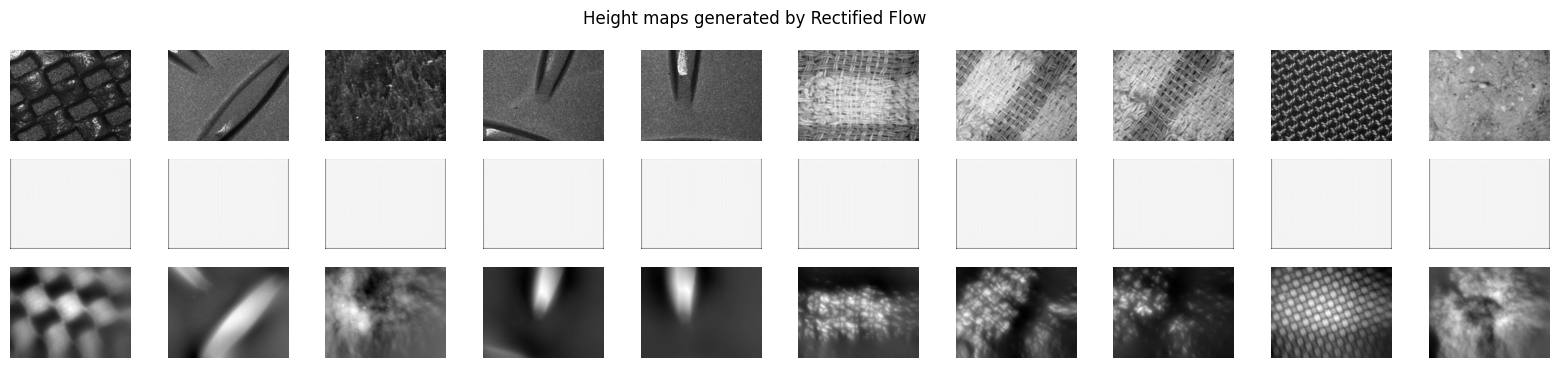

In [20]:
num_samples = 10

@torch.no_grad()
def sample_images(model, image, sample_steps=16):
    image = image.to(device)
    dt = 1.0 / sample_steps
    dt = torch.tensor([dt]).to(device).view([1, *([1] * len(image.shape[1:]))])
    images = [image]
    for i in range(sample_steps, 0, -1):
        t = i / sample_steps
        t = torch.tensor([t]).to(device)

        vc = model(image, t)

        image = image - dt * vc
        image = (image + 1) / 2
        images.append(image)

    return image.cpu().squeeze(0).permute(1, 2, 0).numpy()

dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
(image, heightmap) = next(iter(dataloader))
image, heightmap = image.to(device), heightmap.to(device)

unet.load_state_dict(torch.load('RectifiedUNet.ckpt'))
unet.eval()

# 可视化采样结果
fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 4))
for i in range(num_samples):
    axes[0][i].imshow(image[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    axes[0][i].axis("off")
    axes[1][i].imshow(sample_images(unet, image[i].unsqueeze(0)), cmap="gray")
    axes[1][i].axis("off")
    axes[2][i].imshow(heightmap[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    axes[2][i].axis("off")
plt.suptitle("Height maps generated by Rectified Flow")
plt.show()

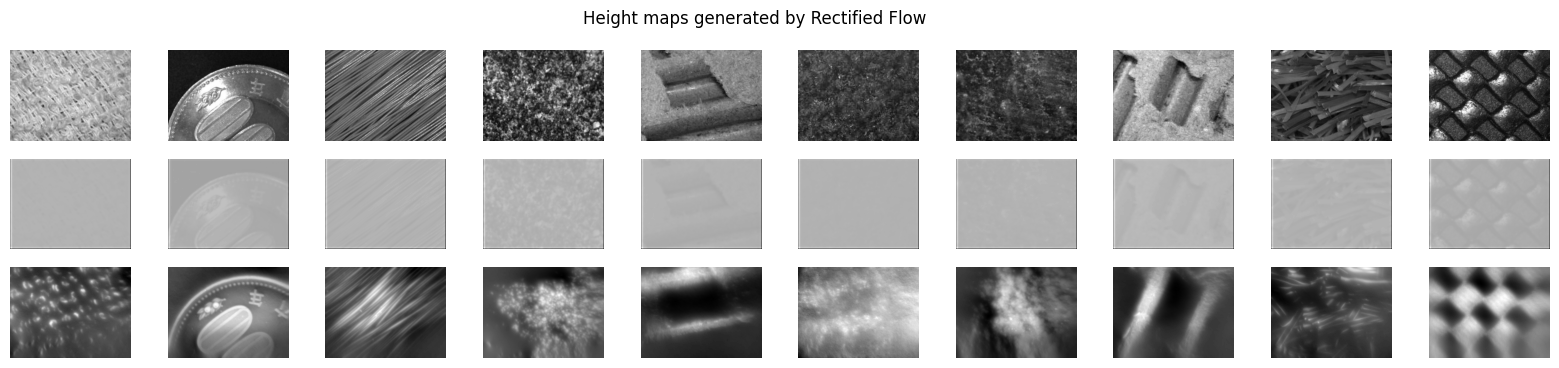

In [21]:
num_samples = 10

@torch.no_grad()
def sample_images(model, image):
    xT = image
    xT = xT.to(device)
    # xT = torch.randn_like(xT) * 0.5 + xT * 0.5
    
    # 定义时间序列 t，从 1 到 0（逆向积分）
    t = torch.linspace(1., 0., 16).to(device)  # 时间步
    
    # 需要扩展 xT 为 [num_samples, 784]，每个样本的初始噪声是独立的
    # 在 odeint 中，t 会被自动广播为 [num_samples, num_steps]
    # 使用 lambda 表达式在每个时间步计算 v_theta(x, t)
    x0_hat = odeint(lambda t, x: model(x, torch.tensor([t]).to(device)), xT, t) 
    # 取最后一步 t=0 的结果（即最终生成的样本）
    x0_hat = x0_hat[-1].cpu().detach()
    
    # 反归一化到 [0,1]
    x0_hat = (x0_hat + 1) / 2
    x0_hat = x0_hat.squeeze(0).permute(1, 2, 0).numpy()
    return x0_hat

dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
(image, heightmap) = next(iter(dataloader))
image, heightmap = image.to(device), heightmap.to(device)

unet.load_state_dict(torch.load('RectifiedUNet.ckpt'))
unet.eval()

# 可视化采样结果
fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 4))
for i in range(num_samples):
    axes[0][i].imshow(image[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    axes[0][i].axis("off")
    axes[1][i].imshow(sample_images(unet, image[i].unsqueeze(0)), cmap="gray")
    axes[1][i].axis("off")
    axes[2][i].imshow(heightmap[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    axes[2][i].axis("off")
plt.suptitle("Height maps generated by Rectified Flow")
plt.show()
